In [1]:
from datetime import date
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine
from sqlalchemy.orm import sessionmaker

from nea_schema.esi.uni import Jumps, Kills
from nea_schema.sde.map import Region, Constellation, System
from config.config import sql_params
from tools import fourier, wave

sns.set()

In [2]:
region_id = 10000068

In [3]:
engine = create_engine('{engine}://{user}:{passwd}@{host}/{db}'.format(**sql_params))
session = sessionmaker(bind=engine)
conn = session()

query = conn.query(
    Jumps.record_time,
    Jumps.system_id,
    Jumps.ship_jumps,
).join(System).join(Constellation)\
    .filter(Constellation.region_id == region_id)\
    .filter(Jumps.record_time >= date(2020,1,1))
jumps_data = pd.read_sql(query.statement, query.session.bind)

jumps_data['hour_of_day'] = jumps_data['record_time'].apply(lambda x: x.hour + (x.minute/60) + (x.second/60/60))
jumps_data['day_of_week'] = jumps_data['record_time'].apply(lambda x: x.weekday() + (x.hour/24) + (x.minute/24/60) + (x.second/24/60/60))

In [4]:
day_wave = fourier(jumps_data, 'ship_jumps', 'hour_of_day', 24, group_col='system_id')
week_wave = fourier(jumps_data, 'ship_jumps', 'day_of_week', 7, group_col='system_id')

In [5]:
buffer = []
for group, data in jumps_data.groupby('system_id'):
    data = data.copy()
    data['day_wave'] = wave(data['hour_of_day'], 24, *day_wave.loc[group])
    data['week_wave'] = wave(data['day_of_week'], 7, *week_wave.loc[group])
    data['full_wave'] = wave(data['hour_of_day'], 24, *day_wave.loc[group]) + wave(data['day_of_week'], 7, **week_wave.loc[group]) - week_wave.loc[group, 'offset']
    data['residual'] = data['ship_jumps'] - data['full_wave']
    buffer.append(data)
jumps_data = pd.concat(buffer, axis=0)

In [ ]:
systems = jumps_data['system_id'].unique().size
fig, ax = plt.subplots(systems, figsize=(14,8*systems))
i = 0
for system_id, data in jumps_data.groupby('system_id'):
    sns.lineplot(x=data.index, y=data['ship_jumps'], label='actual', ax=ax[i])
    sns.lineplot(x=data.index, y=data['full_wave'], label='full_wave', ax=ax[i])
    ax[i].set_title(system_id)
    i += 1

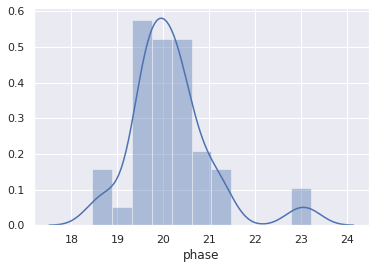

In [6]:
sns.distplot(day_wave['phase'])

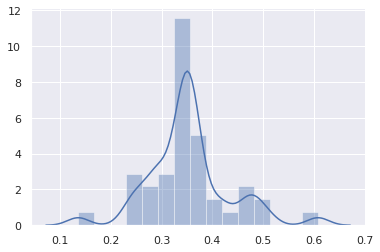

In [10]:
sns.distplot(day_wave['amplitude'] / day_wave['offset'])

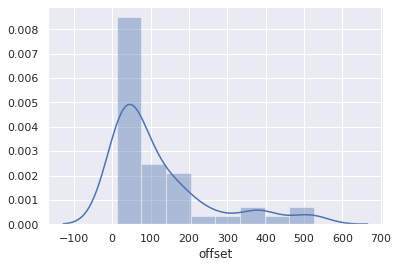

In [11]:
sns.distplot(day_wave['offset'])